# Advanced Lane Line Finding

## Camera Calibration and removing the distortion

### Run the code in the cell below to extract object points and image points for camera calibration.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob("camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

cv2.destroyAllWindows()

###  you should now have objpoints and imgpoints needed for camera calibration. Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

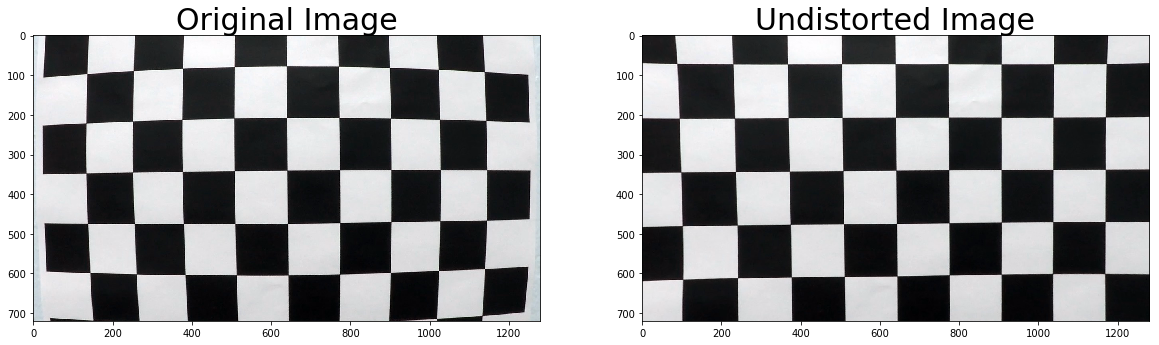

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

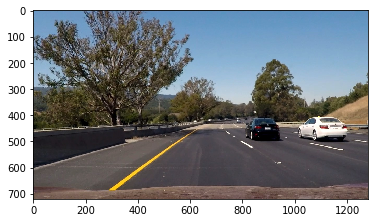

In [37]:
# Demontrate distortion on one of the test image
img = mpimg.imread('test_images/test6.jpg')
img_size = (img.shape[1], img.shape[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)

## Color and gradient transform to create thresholded binary image.

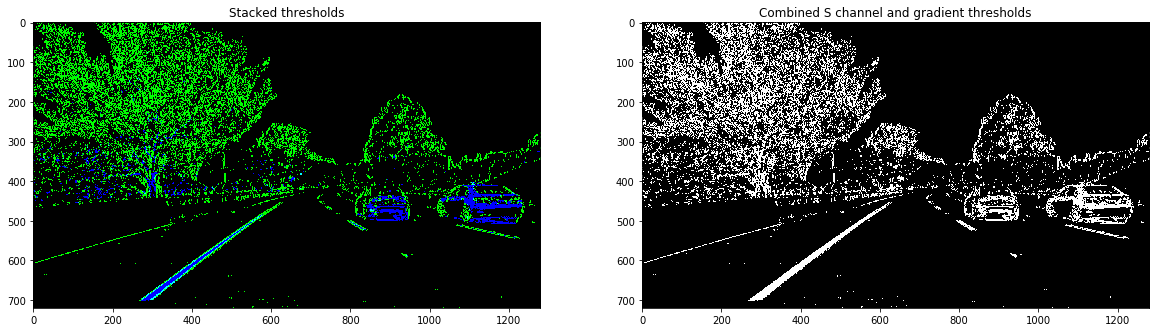

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def color_gradient_transform(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Undistort the image using the distortion coefficients, calculated above.
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Seperate the R channel
    r_channel = img[:,:,0]
    
    # Convert to HLS color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

# Check the result with the test image
image = mpimg.imread('test_images/test6.jpg')
color_binary, combined_binary = color_gradient_transform(image)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## Perspective transform to get the birds-eye view

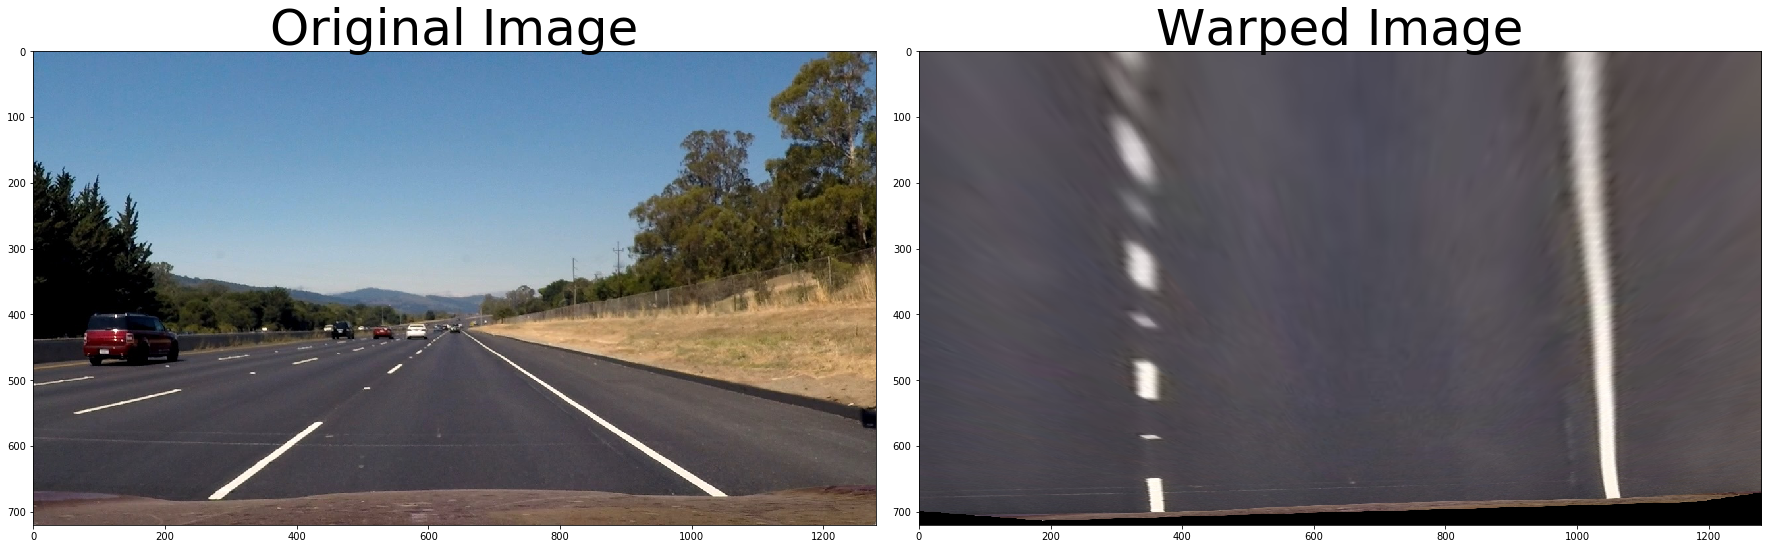

In [5]:
# 1) Undistort using mtx and dist
img6 = cv2.imread('camera_cal/calibration6.jpg')
undst = cv2.undistort(img6, mtx, dist, None, mtx)

nx = 9
ny = 6

# 2) Convert to grayscale
gray = cv2.cvtColor(undst,cv2.COLOR_BGR2GRAY)
    
# 3) Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
# 4) If corners found: 
if ret:     
    # For source points I'm grabbing the four relevant points
    src = np.float32([(260,680), (1040,780), (668, 440), (612, 440)])

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([(350, 700), (950, 700), (950, 0), (350, 0)])

    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # e) Inverse tranform to go back to the original image
    Minv = cv2.getPerspectiveTransform(dst, src)

    # f) use cv2.warpPerspective() to warp your image to a top-down view
    image = mpimg.imread('test_images/straight_lines2.jpg')
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

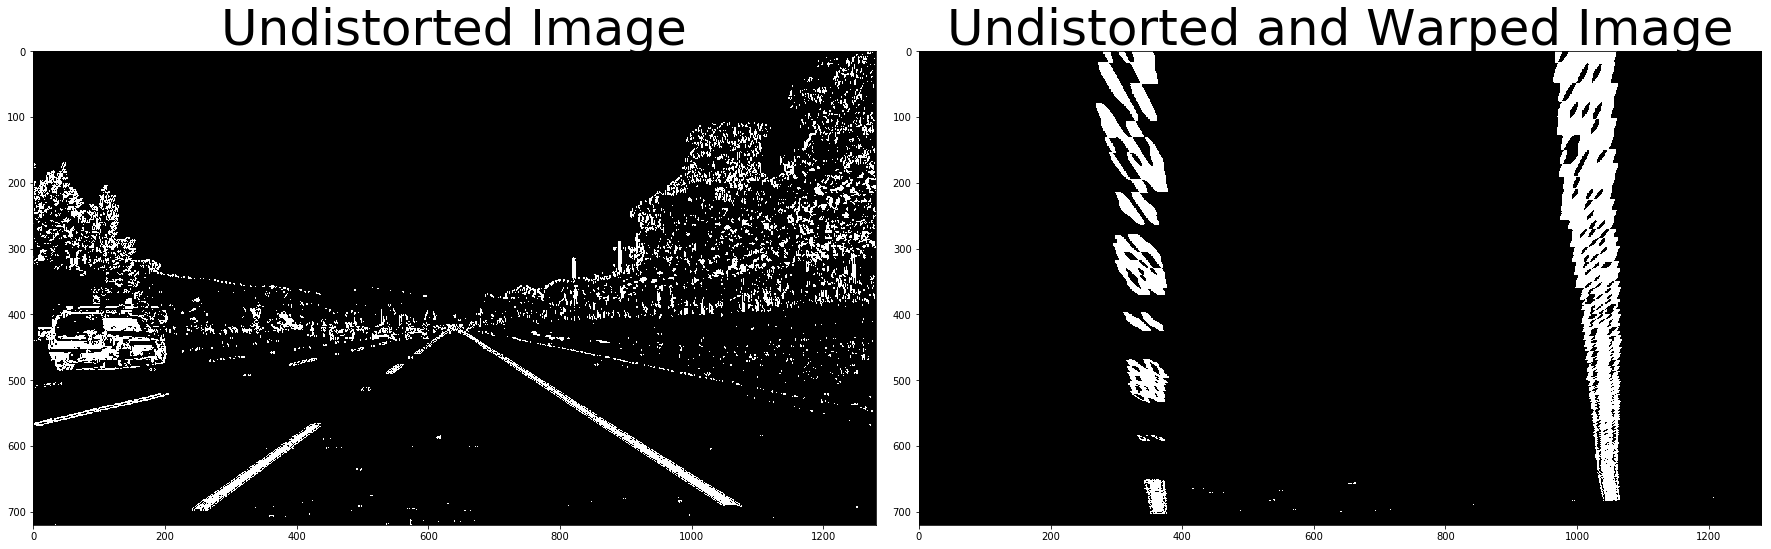

In [6]:
# Lets bring all the above steps together and check out the transform
image = mpimg.imread('test_images/straight_lines2.jpg')
color_binary, combined_binary = color_gradient_transform(image)
warped_image = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels

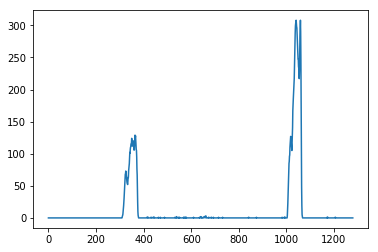

In [7]:
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [26]:
# Define a class to receive the characteristics of each line detection
class Line():
    X = 1280
    Y = 720
    ym_per_pix = 30/Y
    xm_per_pix = 3.7/X
    ploty = np.linspace(0, Y-1, num=Y)
    
    def __init__(self):
        self.counter = 0
        # was the line detected in the last iteration?
        self.detected = False     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
    def set_fit(self, fit):
        self.counter += 1
        self.current_fit = fit
        if self.best_fit != None:
            self.best_fit = (self.best_fit + fit)/2
        else:
            self.best_fit = fit
        self.roc()
            
    def roc(self):
        x = self.current_fit[0] * Line.ploty**2 + self.best_fit[1] * Line.ploty + self.best_fit[2]
        fit = np.polyfit(Line.ploty * Line.ym_per_pix, x * Line.xm_per_pix, 2)
        y_closest = np.max(Line.ploty)
        y_closest = y_closest*Line.ym_per_pix
        self.line_base_pos = y_closest
        self.radius_of_curvature = ((1 + (2*fit[0]*y_closest  + fit[1])**2)**1.5 )/(2*np.absolute(fit[0]))

In [14]:
def detect_line_pixel_first(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

(720, 0)

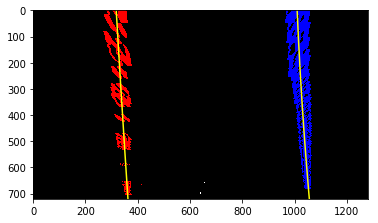

In [106]:
left_fit, right_fit = detect_line_pixel_first(warped_image)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [15]:
def detect_line_pixel_later(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

In [22]:
def visualize_line(undist, binary_warped, left_fit, right_fit):
#     # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Radius Of curvature     
    text = "Radius of curvature: " + str((left_line.radius_of_curvature + right_line.radius_of_curvature)/2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text, (25,100), font, 1, (255,255,255), 2)
    
    # Distance from center
    camera_position = undist.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(camera_position - lane_center)
    center_offset_meter = abs((center_offset_pixels * 3.7) / undist.shape[1])
    text = "Distance from center: " + str(center_offset_meter)
    cv2.putText(result, text, (25,150), font, 1, (255,255,255), 2)
    
    return result

In [27]:
def detect_line_pixel(image):
    color_binary, combined_binary = color_gradient_transform(image)
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    # start fresh at every 100th frame
    if left_line.counter == 100:
        left_line.counter = 0
        left_line.detected = False
    if not left_line.detected:
        left_fit, right_fit = detect_line_pixel_first(binary_warped)
        left_line.detected = True
        right_line.detected = True
    else:
        left_fit, right_fit = detect_line_pixel_later(binary_warped, left_line.best_fit, right_line.best_fit)
    left_line.set_fit(left_fit)
    right_line.set_fit(right_fit)
    binary_warped = visualize_line(image, binary_warped, left_line.best_fit, right_line.best_fit)
    return binary_warped

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

# Initilize left and the right line object
left_line = Line()
right_line = Line()

output_video = 'project_video_solution.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(detect_line_pixel)
%time yellow_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [04:14<00:00,  4.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 4min 12s, sys: 1min 6s, total: 5min 18s
Wall time: 4min 16s
